In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

In [32]:
consDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-consDF.pqt")
consDF = consDF.drop(columns = ["credit_score"])
consDF = consDF.dropna()
acctDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt")
trxnDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt")
catmap = pd.read_csv("/uss/hdsi-prismdata/q2-ucsd-cat-map.csv")

### Aggregated Balance Features (total, avg, max, min, std)

In [33]:
agg_bal = (
    acctDF
    .groupby("prism_consumer_id")["balance"]
    .agg(
        total_balance="sum",
        avg_balance="mean",
        max_balance="max",
        min_balance="min",
        std_balance="std",
        num_accounts="count"
    )
    .reset_index()
)
agg_bal

,prism_consumer_id,total_balance,avg_balance,max_balance,min_balance,std_balance,num_accounts
0,0,320.37,160.185,294.67,25.70,190.190511,2
1,1,3302.42,1651.210,3211.18,91.24,2206.130731,2
2,10,824.24,412.120,822.75,1.49,580.718515,2
3,100,2655.47,1327.735,1853.07,802.40,742.935882,2
4,1000,95.25,47.625,95.23,0.02,67.323637,2
...,...,...,...,...,...,...,...
13004,9995,0.00,0.000,0.00,0.00,NaN,1
13005,9996,252.67,252.670,252.67,252.67,NaN,1
13006,9997,611.28,611.280,611.28,611.28,NaN,1
13007,9998,-862.99,-862.990,-862.99,-862.99,NaN,1


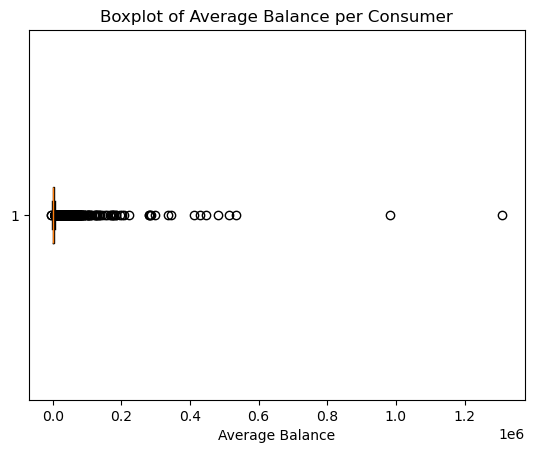

In [34]:
plt.figure()
plt.boxplot(agg_bal["avg_balance"].dropna(), vert=False)
plt.xlabel("Average Balance")
plt.title("Boxplot of Average Balance per Consumer")
plt.show()

### Balance in Checkings and Savings account respectively

In [35]:
pivot_bal = (
    acctDF
    .pivot_table(
        index="prism_consumer_id",
        columns="account_type",
        values="balance",
        aggfunc="sum",
        fill_value=0
    )
    .reset_index()
)

pivot_bal["checking_to_savings_ratio"] = (
    pivot_bal.get("CHECKING", 0) / (pivot_bal.get("SAVINGS", 0) + 1)
)

pivot_bal["has_savings_account"] = (pivot_bal.get("SAVINGS", 0) > 0).astype(int)
keep_cols = [
    "prism_consumer_id",
    "CHECKING",
    "SAVINGS",
    "checking_to_savings_ratio",
    "has_savings_account"
]

pivot_bal = pivot_bal[keep_cols]
pivot_bal

account_type,prism_consumer_id,CHECKING,SAVINGS,checking_to_savings_ratio,has_savings_account
0,0,294.67,25.70,11.036330,1
1,1,91.24,3211.18,0.028404,1
2,10,822.75,1.49,330.421687,1
3,100,802.40,1853.07,0.432778,1
4,1000,95.23,0.02,93.362745,1
...,...,...,...,...,...
13004,9995,0.00,0.00,0.000000,0
13005,9996,252.67,0.00,252.670000,0
13006,9997,611.28,0.00,611.280000,0
13007,9998,-862.99,0.00,-862.990000,0


/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


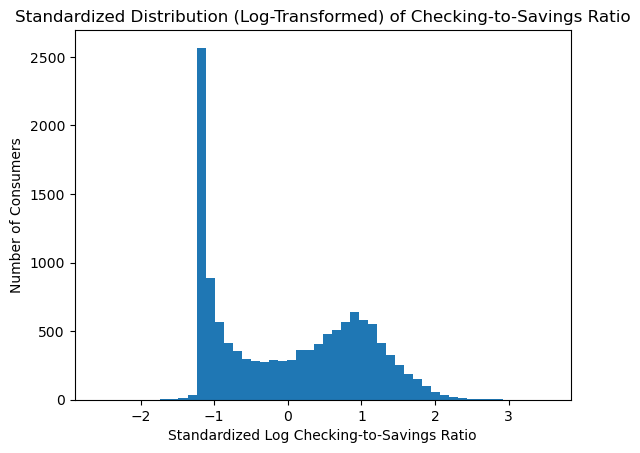

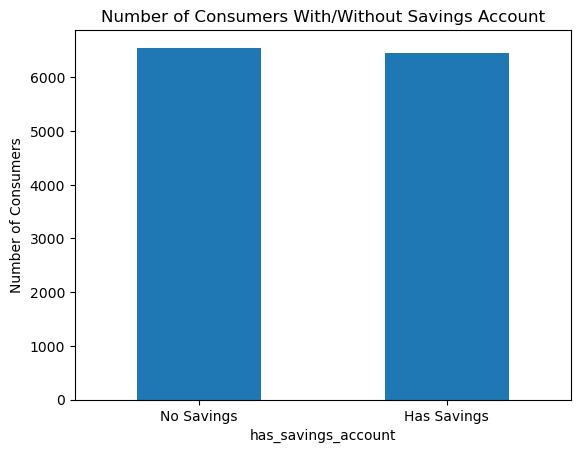

In [36]:
pivot_bal["log_checking_to_savings_ratio"] = np.log1p(pivot_bal["checking_to_savings_ratio"])

# Standardize
scaler = StandardScaler()
pivot_bal["std_log_checking_to_savings_ratio"] = scaler.fit_transform(
    pivot_bal[["log_checking_to_savings_ratio"]]
)

# Quick check
plt.figure()
plt.hist(pivot_bal["std_log_checking_to_savings_ratio"], bins=50)
plt.xlabel("Standardized Log Checking-to-Savings Ratio")
plt.ylabel("Number of Consumers")
plt.title("Standardized Distribution (Log-Transformed) of Checking-to-Savings Ratio")
plt.show()

pivot_bal["has_savings_account"].value_counts().plot(kind="bar")
plt.xticks([0,1], ["No Savings", "Has Savings"], rotation=0)
plt.ylabel("Number of Consumers")
plt.title("Number of Consumers With/Without Savings Account")
plt.show()

### Liquid Balance (Checkings + Savings)

In [37]:
acctDF["liquid_balance"] = (
    acctDF
    .assign(
        liquid_component=lambda df: np.where(
            df["account_type"].isin(["CHECKING", "SAVINGS"]),
            df["balance"],
            0
        )
    )
    .groupby("prism_consumer_id")["liquid_component"]
    .transform("sum")
)
acctDF["low_liquidity"] = (acctDF["liquid_balance"] < 500).astype(int)
acctDF["is_liquid"] = (acctDF["liquid_balance"] > 0).astype(int)
acctDF


,prism_consumer_id,prism_account_id,account_type,balance_date,balance,liquid_balance,low_liquidity,is_liquid
0,3023,0,SAVINGS,2021-08-31,90.57,316.52,1,1
1,3023,1,CHECKING,2021-08-31,225.95,316.52,1,1
2,4416,2,SAVINGS,2022-03-31,15157.17,15223.59,0,1
3,4416,3,CHECKING,2022-03-31,66.42,15223.59,0,1
4,4227,4,CHECKING,2021-07-31,7042.90,7042.90,0,1
...,...,...,...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75,732.75,0,1
24462,11615,24462,SAVINGS,2022-03-30,5.00,9928.91,0,1
24463,11615,24463,CHECKING,2022-03-30,1956.46,9928.91,0,1
24464,12210,24464,CHECKING,2022-03-28,2701.51,2701.51,0,1


### Income Features

In [38]:
trxnDF = trxnDF.merge(
    catmap,
    left_on="category",
    right_on="category_id",
    how="left"
)

trxnDF

,prism_consumer_id,prism_transaction_id,category_x,amount,credit_or_debit,posted_date,category_id,category_y
0,3023,0,4,0.05,CREDIT,2021-04-16,4,MISCELLANEOUS
1,3023,1,12,481.56,CREDIT,2021-04-30,12,LOAN
2,3023,2,4,0.05,CREDIT,2021-05-16,4,MISCELLANEOUS
3,3023,3,4,0.07,CREDIT,2021-06-16,4,MISCELLANEOUS
4,3023,4,4,0.06,CREDIT,2021-07-16,4,MISCELLANEOUS
...,...,...,...,...,...,...,...,...
6407316,10533,6405304,31,4.96,DEBIT,2022-03-11,31,BILLS_UTILITIES
6407317,10533,6405305,12,63.48,DEBIT,2022-03-30,12,LOAN
6407318,10533,6405306,12,53.99,DEBIT,2022-03-30,12,LOAN
6407319,10533,6405307,12,175.98,DEBIT,2022-03-31,12,LOAN


In [39]:
INCOME_CATEGORIES = [
    "DEPOSIT",
    "PAYCHECK",
    "PAYCHECK_PLACEHOLDER",
    "INVESTMENT_INCOME",
    "OTHER_BENEFITS",
    "UNEMPLOYMENT_BENEFITS",
    "PENSION"
]
trxnDF["posted_date"] = pd.to_datetime(trxnDF["posted_date"])
income_txn = trxnDF[
    (trxnDF["credit_or_debit"] == "CREDIT") &
    (trxnDF["category_y"].isin(INCOME_CATEGORIES))
].copy()
income_txn["month"] = income_txn["posted_date"].dt.to_period("M")

income_txn

,prism_consumer_id,prism_transaction_id,category_x,amount,credit_or_debit,posted_date,category_id,category_y,month
10,3023,10,2,208.05,CREDIT,2021-04-06,2,DEPOSIT,2021-04
17,3023,17,3,900.00,CREDIT,2021-05-07,3,PAYCHECK,2021-05
19,3023,19,2,800.00,CREDIT,2021-05-08,2,DEPOSIT,2021-05
20,3023,20,2,300.00,CREDIT,2021-05-23,2,DEPOSIT,2021-05
21,3023,21,3,300.00,CREDIT,2021-06-04,3,PAYCHECK,2021-06
...,...,...,...,...,...,...,...,...,...
6407236,10533,6405224,8,1682.00,CREDIT,2022-01-31,8,OTHER_BENEFITS,2022-01
6407240,10533,6405228,8,841.00,CREDIT,2022-02-27,8,OTHER_BENEFITS,2022-02
6407241,10533,6405229,8,841.00,CREDIT,2022-02-27,8,OTHER_BENEFITS,2022-02
6407244,10533,6405232,8,841.00,CREDIT,2022-03-30,8,OTHER_BENEFITS,2022-03


In [40]:
total_income = (
    income_txn
    .groupby("prism_consumer_id")["amount"]
    .sum()
    .reset_index(name="total_income")
)
total_income

,prism_consumer_id,total_income
0,0,9320.56
1,1,13411.59
2,10,15420.74
3,100,24411.78
4,1000,48378.60
...,...,...
13873,9995,11226.84
13874,9996,0.03
13875,9997,16672.86
13876,9998,7203.23


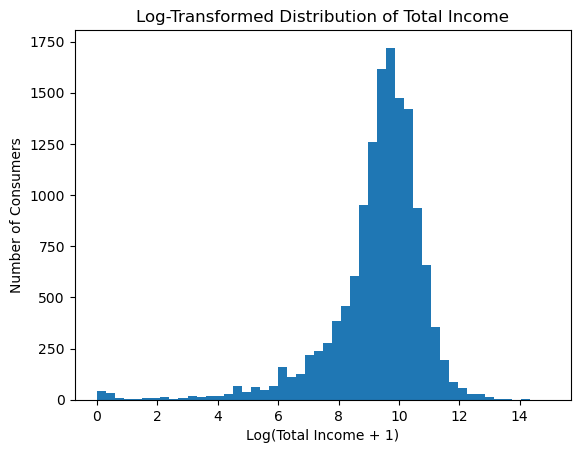

In [45]:
plt.figure()
plt.hist(np.log1p(total_income["total_income"]), bins=50)
plt.xlabel("Log(Total Income + 1)")
plt.ylabel("Number of Consumers")
plt.title("Log-Transformed Distribution of Total Income")
plt.show()

In [46]:
avg_monthly_income = (
    income_txn
    .groupby(["prism_consumer_id", "month"])["amount"]
    .sum()
    .groupby("prism_consumer_id")
    .mean()
    .reset_index(name="avg_monthly_income")
)
avg_monthly_income

,prism_consumer_id,avg_monthly_income
0,0,1331.508571
1,1,1915.941429
2,10,2202.962857
3,100,4068.630000
4,1000,6911.228571
...,...,...
13873,9995,3742.280000
13874,9996,0.010000
13875,9997,4168.215000
13876,9998,2401.076667


In [47]:
income_consistency = (
    income_txn
    .groupby("prism_consumer_id")["month"]
    .nunique()
    .reset_index(name="num_income_months")
)
income_consistency

,prism_consumer_id,num_income_months
0,0,7
1,1,7
2,10,7
3,100,6
4,1000,7
...,...,...
13873,9995,3
13874,9996,3
13875,9997,4
13876,9998,3


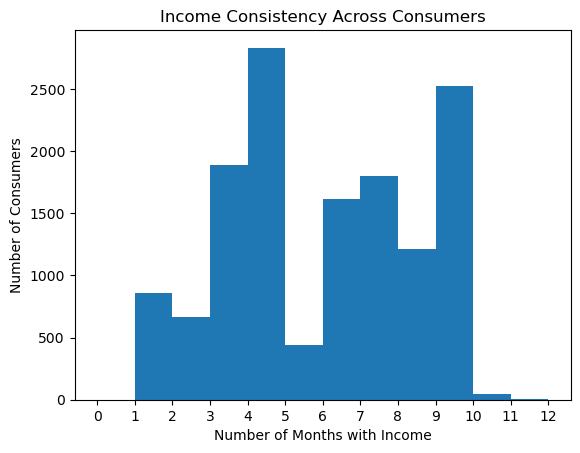

In [48]:
plt.figure()
plt.hist(income_consistency["num_income_months"], bins=range(0, 13))
plt.xlabel("Number of Months with Income")
plt.ylabel("Number of Consumers")
plt.title("Income Consistency Across Consumers")
plt.xticks(range(0,13))
plt.show()

In [49]:
income_sources = (
    income_txn
    .groupby("prism_consumer_id")["category_y"]
    .nunique()
    .reset_index(name="num_income_sources")
)
income_sources

,prism_consumer_id,num_income_sources
0,0,2
1,1,2
2,10,2
3,100,1
4,1000,2
...,...,...
13873,9995,1
13874,9996,1
13875,9997,2
13876,9998,1


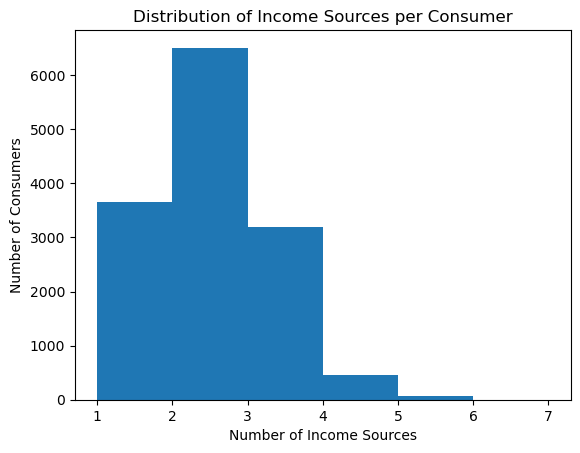

In [52]:
plt.figure()
plt.hist(income_sources["num_income_sources"], bins=range(1, income_sources["num_income_sources"].max() + 2))
plt.xlabel("Number of Income Sources")
plt.ylabel("Number of Consumers")
plt.title("Distribution of Income Sources per Consumer")
plt.show()

In [59]:
benefits_flag = (
    income_txn[income_txn["category_x"].isin([8, 9, 49])]
    .groupby("prism_consumer_id")
    .size()
    .reset_index(name="benefits_txn_count")
)

benefits_flag["has_benefits_income"] = (
    benefits_flag["benefits_txn_count"] > 0
).astype(int)
benefits_flag

,prism_consumer_id,benefits_txn_count,has_benefits_income
0,10007,1,1
1,10009,1,1
2,10015,28,1
3,10020,11,1
4,10039,3,1
...,...,...,...
2021,9943,3,1
2022,9950,1,1
2023,9962,12,1
2024,9981,5,1


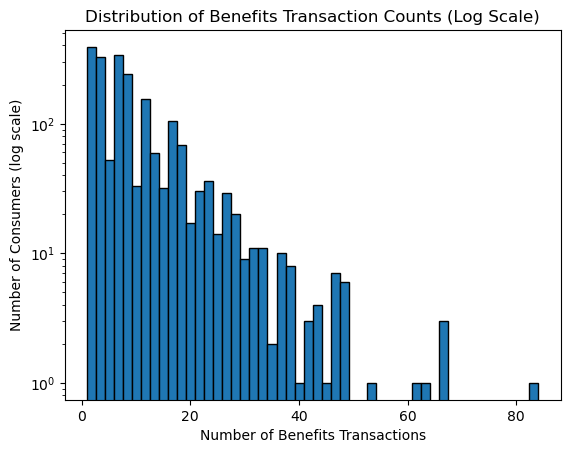

In [62]:
plt.figure()
plt.hist(benefits_flag["benefits_txn_count"], bins=50, log=True, edgecolor='k')
plt.xlabel("Number of Benefits Transactions")
plt.ylabel("Number of Consumers (log scale)")
plt.title("Distribution of Benefits Transaction Counts (Log Scale)")
plt.show()